# Case Study: Finetuning Text2SQL model

## Python Dependency

For reproducibility purposes, we documented the required dependency to make the notebook run smoothly.

In [1]:
!pip show transformers datasets tokenizers sentencepiece huggingface-hub torch accelerate peft bitsandbytes accelerate sqlparse sqlglot5 numpy pandas jupyterlab ipykernel tqdm python-dotenv matplotlib seaborn plotly scikit-learn scipy nltk spacy gensim beautifulsoup4 lxml requests flask fastapi uvicorn pytest black mypy pylint bandit pre-commit


Name: transformers
Version: 5.0.0
Summary: Transformers: the model-definition framework for state-of-the-art machine learning models in text, vision, audio, and multimodal models, for both inference and training.
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, safetensors, tokenizers, tqdm, typer-slim
Required-by: peft
---
Name: datasets
Version: 2.19.1
Summary: HuggingFace community-driven open-source library of datasets
Home-page: https://github.com/huggingface/datasets
Author: HuggingFace Inc.
Author-email: thomas@huggingface.co
License: Apache 2.0
Location: /usr/local/lib/python3.10/site-packages
Requires: aiohttp, dill, filelock, fsspec, 

In [1]:
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    BitsAndBytesConfig,
    AutoConfig
)
from peft import LoraConfig, get_peft_model,prepare_model_for_kbit_training

# Tools for EDA
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import numpy as np
from collections import Counter
import pickle
import random

# If you use Google Drive
# from google.colab import drive
# drive.mount('/content/drive')


## Objective
The goal is to train an LLM model (<3B parameters) for Text2SQL purposes using QLoRA. The notebook is designed to run with the following minimum **6GB RAM of GPU**. 

Although accuracy is not the primary goal, **we are expecting the model to generate syntactically valid and executable SQL queries** from natural language questions.

## Model Preparation
QLoRA is a variation of LoRA, where we strictly set the the data types of the weight into certain precision , to reduce the usage of RAM memory during training. 

LoRA itself is an optimization finetuning method where we freeze the pretrained model, add a matrix with rank $r$ (which should be much smaller than $d_{in}$ and $d_{out}$) and only train the added matrix. 

In [2]:
def prepare_model_module(
    model_name:str,
    lora_config_dict:dict
):
    tokenizer = AutoTokenizer.from_pretrained(f"{model_name}")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",          # QLoRA paper
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True
    )
    frozen_model = AutoModelForCausalLM.from_pretrained(
        model_name, 
        quantization_config = bnb_config,
        device_map = "auto",
        torch_dtype = torch.float16
    )

    frozen_model.config.pad_token_id = tokenizer.pad_token_id

    frozen_quantized_model = prepare_model_for_kbit_training(frozen_model)

    peft_config = LoraConfig(
        r = lora_config_dict["r"],
        lora_alpha = lora_config_dict["lora_alpha"],
        target_modules = lora_config_dict["target_modules"],
        lora_dropout = 0.05,
        bias= "none"
    )
    model = get_peft_model(frozen_quantized_model, peft_config)
    model.print_trainable_parameters()

    config = {
        "bnb": bnb_config,
        "peft": peft_config
    }

    return tokenizer, frozen_model, frozen_quantized_model, model, config


## Dataset Preparation

In [ ]:
DATASET_ID = "birdsql/bird23-train-filtered"
dataset = load_dataset(DATASET_ID)

In [5]:
print(f"Basic Information:\n{dataset}")

# Examples: Sample 2 datapoints
sampled_data = dataset["train"].shuffle(seed=42).select(range(2))
for q, e, s in zip(sampled_data["question"], sampled_data["evidence"], sampled_data["SQL"]):
    print(f"\nQuestion: {q}\nEvidence: {e}\nExpected SQL: {s}")

# db_id (categories) distribution
categories_bin_dict = Counter(dataset["train"]["db_id"])

print(f"\nCategories Distribution:")
for cat, count in categories_bin_dict.most_common():
    print(f"{cat}: {count}")



Basic Information:
DatasetDict({
    train: Dataset({
        features: ['db_id', 'question', 'evidence', 'SQL'],
        num_rows: 6601
    })
})

Question: How many criteria belong to ranking system ID 3?
Evidence: 
Expected SQL: SELECT COUNT(id) FROM ranking_criteria WHERE ranking_system_id = 3

Question: How many 10-star votes were given to the episode titled "Cherished"?
Evidence: 10-star vote refers to stars = 10; titled "Cherished" refers to title = 'Cherished'
Expected SQL: SELECT T2.votes FROM Episode AS T1 INNER JOIN Vote AS T2 ON T1.episode_id = T2.episode_id WHERE T1.title = 'Cherished' AND T2.stars = 10

Categories Distribution:
works_cycles: 383
public_review_platform: 256
movie_3: 223
mondial_geo: 211
soccer_2016: 190
books: 184
simpson_episodes: 164
student_loan: 162
olympics: 156
hockey: 156
retails: 155
video_games: 152
movies_4: 143
synthea: 141
legislator: 128
chicago_crime: 128
address: 126
retail_complains: 120
university: 120
talkingdata: 118
professional_basketb

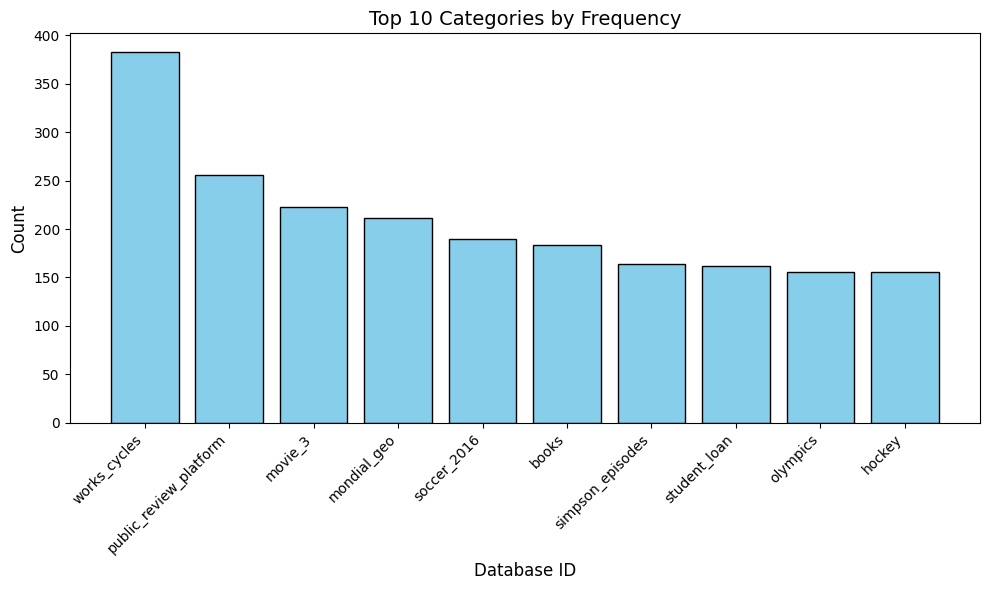

In [6]:
top_10 = categories_bin_dict.most_common(10)

labels, values = zip(*top_10)

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue', edgecolor='black')
plt.title("Top 10 Categories by Frequency", fontsize=14)
plt.xlabel("Database ID", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotates labels to prevent overlapping
plt.tight_layout()
plt.show()

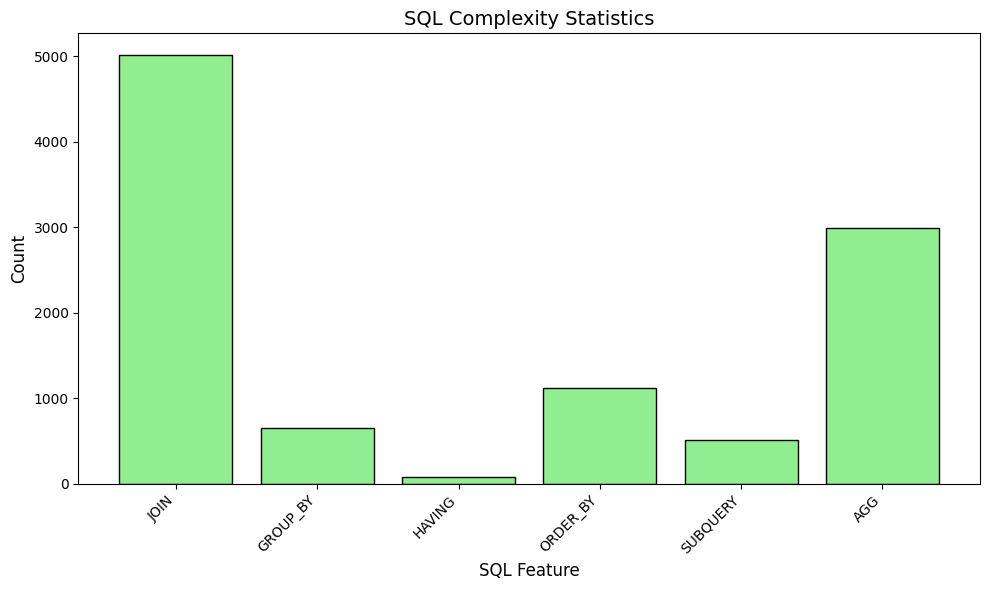

In [7]:
def analyze_sql_complexity(sql):
    ops = {
        "JOIN": len(re.findall(r"\bJOIN\b", sql, re.I)),
        "GROUP_BY": int("GROUP BY" in sql.upper()),
        "HAVING": int("HAVING" in sql.upper()),
        "ORDER_BY": int("ORDER BY" in sql.upper()),
        "SUBQUERY": int("SELECT" in sql.upper()[1:]),
        "AGG": sum(sql.upper().count(x) for x in ["COUNT(", "SUM(", "AVG(", "MAX(", "MIN("])
    }
    return ops

stats = defaultdict(int)
for row in dataset["train"]:
    ops = analyze_sql_complexity(row["SQL"])
    for k, v in ops.items():
        stats[k] += int(v > 0)

# Visualize SQL Complexity Statistics
labels = list(stats.keys())
values = list(stats.values())
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='lightgreen', edgecolor='black')
plt.title("SQL Complexity Statistics", fontsize=14)
plt.xlabel("SQL Feature", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


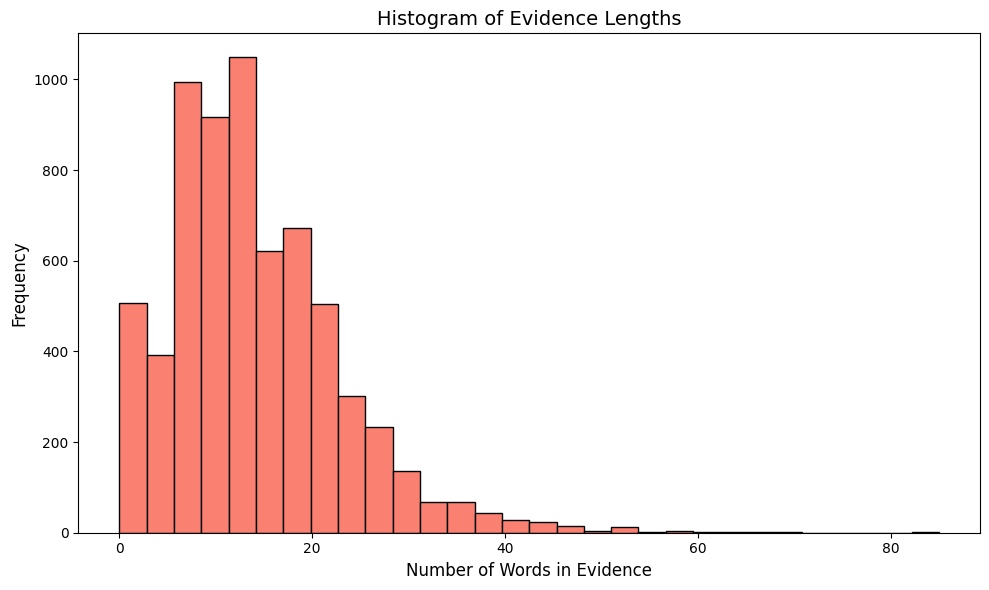

In [8]:
evidence_lengths = [len(row["evidence"].split()) for row in dataset["train"]]
plt.figure(figsize=(10, 6))
plt.hist(evidence_lengths, bins=30, color='salmon', edgecolor='black')
plt.title("Histogram of Evidence Lengths", fontsize=14)
plt.xlabel("Number of Words in Evidence", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

#### **Sampling Dataset**

Based on data analysis and the limited GPU resource, we sample 40% from the dataset. We bucket the evidence length and sample from each bucket 40%, preserving the distribution of the data. 

In [4]:
def evidence_len(e):
    return len(str(e).split())

def create_bucket_based_on_evidence_length(evidence_seq):
    bins = [0, 10, 25, 1000]
    evidence_length_array = np.array([evidence_len(e) for e in evidence_seq])
    bucket_labels = np.digitize(evidence_length_array, bins)
    return bucket_labels

def get_row_indices_for_sampling(data, bucket_labels, seed=42, sampling_size = 0.4):
    indices = np.arange(len(data))
    selected_indices = []

    random.seed(42)
    for b in np.unique(bucket_labels):
        bucket_idx = indices[bucket_labels ==b]
        k = int(sampling_size* len(bucket_idx))
        selected_indices.extend(
            random.sample(list(bucket_idx), k)
        )
    
    return selected_indices

    


def prepare_dataset(dataset_id:str,
                    sampling_size = 0.4, 
                    train_size:float=0.6, 
                    val_to_test_ratio:float=0.5, 
                    seed:int=42
                    ):
    dataset = load_dataset(dataset_id)
    bucket_labels = create_bucket_based_on_evidence_length(dataset["train"]["evidence"])
    row_indices = get_row_indices_for_sampling(dataset["train"], bucket_labels, seed, sampling_size)
    
    sampled_dataset = dataset["train"].select(row_indices)
    tmp = sampled_dataset.train_test_split(test_size=(1-train_size), seed=seed)
    train_data = tmp["train"]
    tmp_2 = tmp["test"].train_test_split(test_size=val_to_test_ratio, seed=seed)
    val_data = tmp_2["train"]
    test_data = tmp_2["test"]
    return dataset, sampled_dataset, train_data, val_data, test_data

def load_dataset_from_file(filename:str):
    with open(filename, "rb") as f:
        downloaded_dataset_dict = pickle.load(f)

    return downloaded_dataset_dict["dataset"], downloaded_dataset_dict["sampled_dataset"], downloaded_dataset_dict["train_data"], downloaded_dataset_dict["val_data"], downloaded_dataset_dict["test_data"]

## Attention Setup
The objective of the finetuning is to have a model which produces executable SQL syntax. Therefore, we need to define the `labels` as valid SQL syntax only. 

In [3]:
def tokenize_row(example, tokenizer, seq_len=512):
    inputs = []
    labels = []

    for nl, ev, sql in zip(
        example["question"],
        example["evidence"],
        example["SQL"]
    ):
        prompt = f"Question: {nl}\nEvidence: {ev}\nSQL:"
        full_text = prompt + " " + sql

        tokenized = tokenizer(
            full_text,
            truncation=True,
            padding="max_length",
            max_length=seq_len
        )

        input_ids = tokenized["input_ids"]

        # Mask everything BEFORE SQL:
        prompt_len = len(
            tokenizer(prompt, add_special_tokens=False)["input_ids"]
        )

        # ignore the prompt tokens for the loss calculation.
        # Goal: The model should produce SQL syntax only.
        label_ids = [-100] * prompt_len + input_ids[prompt_len:]

        inputs.append(input_ids)
        labels.append(label_ids)

    return {
        "input_ids": inputs,
        "attention_mask": [[1 if t != tokenizer.pad_token_id else 0 for t in ids] for ids in inputs],
        "labels": labels,
    }

def tokenize_dataset(train_data, val_data, test_data, tokenizer):
    tokenized_train = train_data.map(
        lambda example: tokenize_row(example, tokenizer),
        batched=True
    )

    tokenized_val = None
    if val_data:
        tokenized_val = val_data.map(
            lambda example: tokenize_row(example, tokenizer),
            batched=True
        )
    
    tokenized_test = None
    if test_data:
        tokenized_test = test_data.map(
            lambda example: tokenize_row(example, tokenizer),
            batched=True
        )
    return tokenized_train, tokenized_val, tokenized_test

In [5]:
DATASET_ID = "birdsql/bird23-train-filtered"
# Use this if the dataset has not been downloaded yet.
dataset, sampled_dataset, train_data, val_data, test_data = prepare_dataset(DATASET_ID)

# Use this to load the dataset from a local file.
# dataset, sampled_dataset, train_data, val_data, test_data = load_dataset_from_file("/workspace/content/drive/datasets/birdsql_sampled_dataset.pkl")

In [9]:
print(f"\nTrain Data Size: {len(train_data)}")
print(f"Validation Data Size: {len(val_data)}")
print(f"Test Data Size: {len(test_data)}")


Train Data Size: 1583
Validation Data Size: 528
Test Data Size: 528


In [ ]:
MODEL_NAME = "tiiuae/Falcon3-1B-Base"
LORA_CONFIG_R = 32
LORA_CONFIG_LORA_ALPHA = 64
LORA_CONFIG_TARGET_MODULES = ["q_proj","v_proj"]
LORA_CONFIG_LORA_DROPOUT = 0.05
LORA_CONFIG_DICT = {
    "r": LORA_CONFIG_R,
    "lora_alpha": LORA_CONFIG_LORA_ALPHA,
    "target_modules": LORA_CONFIG_TARGET_MODULES,
    "lora_dropout" :LORA_CONFIG_LORA_DROPOUT
}

tokenizer, frozen_model, frozen_quantized_model, model, config = prepare_model_module(
    MODEL_NAME,
    LORA_CONFIG_DICT
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/165 [00:00<?, ?it/s]

trainable params: 4,128,768 || all params: 1,673,537,536 || trainable%: 0.24670901674953527


In [ ]:
# save_path = "/workspace/content/drive/models/my_qwen"

# WARNING: NEVER DO THIS! If the model includes quantization configuration, saving the model like this will not help you when you try to load it back.
# frozen_model.save_pretrained(f"{save_path}_frozen_model")
# frozen_quantized_model.save_pretrained(f"{save_path}_frozen_quantized_model")
# model.save_pretrained(f"{save_path}_model")
# tokenizer.save_pretrained(f"{save_path}_tokenizer")

# import pickle
# with open("/workspace/content/drive/models/my_qwen/bnb_peft_config.pkl", "wb") as f:
#     pickle.dump(config,f)


In [10]:
tokenized_train, tokenized_val, tokenized_test = tokenize_dataset(
    train_data,
    val_data,
    test_data,
    tokenizer
)

## Training Setup Configuration
### 1. Batch Size
- `TRAINING_BATCH_SIZE = 2`
- `VALIDATION_BATCH_SIZE = 2`

A small per-device batch size is required due to GPU memory limitations when fine-tuning a 1B-parameter model, even with QLoRA and quantization. A batch size of 2 allows the model, optimizer states, and LoRA adapters to fit within memory without triggering out-of-memory errors.

Using the same batch size for training and validation ensures consistent memory usage and avoids unexpected failures during evaluation.

### 2.Gradient Accumulation
- `TRAINING_GRADIENT_ACCUMULATION_STEPS = 8`

To compensate for the small per-device batch size, we apply gradient accumulation. This effectively simulates a larger batch size without increasing memory usage.

The effective batch size becomes:

$$
2 \times 8 = 16
$$


This improves gradient stability and convergence behavior while remaining compatible with the available hardware.

### 3.Learning Rate
- `TRAINING_LEARNING_RATE = 2e-5`
A conservative choice for adjusting the learning rate in deep learning model. Larger learning rate could potentially cause overshooting during training. 

### 4. Number of Epochs
- `TRAINING_NUMBER_EPOCH = 3`
Given a reduced dataset and scope of the task, 3 epochs should be sufficient for finetuning the model. This should illusterate the stability of the training. 

### 5. Logging Strategy
- `TRAINING_LOGGING_STEP = 10`
Logging every 10 steps provides sufficient visibility, allowing early detection of divergence or instability while keeping training efficient.

### 6. Checkpointing and Evaluation Strategy
- `TRAINING_SAVE_STRATEGY = "epoch"`
- `TRAINING_EVALUATION_STRATEGY = "epoch"`
Given the size of the training, it is a reasonable choice to save checkpoints and perform validation test after each epoch, which allows us to see the trend of the loss function. 


In [11]:
TRAINING_OUTPUT_DIR = "content/drive/models/falcon"
TRAINING_BATCH_SIZE = 2
VALIDATAION_BATCH_SIZE = 2
TRAINING_GRADIENT_ACCUMULATION_STEPS = 8
TRAINING_LEARNING_RATE = 2e-5
TRAINING_NUMBER_EPOCH = 3
TRAINING_LOGGING_STEP = 10
TRAINING_SAVE_STRATEGY = "epoch"
TRAINING_EVALUATION_STRATEGY = "epoch"

training_args = TrainingArguments(
    output_dir = TRAINING_OUTPUT_DIR,
    per_device_train_batch_size = TRAINING_BATCH_SIZE,
    per_device_eval_batch_size = VALIDATAION_BATCH_SIZE,
    gradient_accumulation_steps = TRAINING_GRADIENT_ACCUMULATION_STEPS,
    learning_rate = TRAINING_LEARNING_RATE,
    num_train_epochs = TRAINING_NUMBER_EPOCH,
    fp16=True,
    logging_steps = TRAINING_LOGGING_STEP,
    save_strategy = TRAINING_SAVE_STRATEGY,
    eval_strategy = TRAINING_EVALUATION_STRATEGY,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    report_to= "none"
)

from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=(tokenized_val if val_data else None),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

trainer.save_model(TRAINING_OUTPUT_DIR)
tokenizer.save_pretrained(TRAINING_OUTPUT_DIR)

/usr/local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:1181: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,11.252808,10.889053
2,9.921056,9.725377
3,9.381837,9.224278


/usr/local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:1181: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:1181: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/pyt

('content/drive/models/qwen/tokenizer_config.json',
 'content/drive/models/qwen/tokenizer.json')

## Test Dataset Evaluation
This shows the performance of the best model under unseen data. 

In [12]:
# test the model with unseen data
if tokenized_test:
    test_results = trainer.evaluate(tokenized_test)
    print("Test Results:", test_results)

Test Results: {'eval_loss': 9.262227058410645, 'eval_runtime': 60.1858, 'eval_samples_per_second': 8.773, 'eval_steps_per_second': 4.386, 'epoch': 3.0}


## Example

In [13]:
SAMPLE_INDEX_LIST = [37,50]
for sample_index in SAMPLE_INDEX_LIST:
    question = tokenized_test["question"][sample_index]
    evidence = tokenized_test["evidence"][sample_index]
    input_text = f"Question: {question}\nEvidence: {evidence}\nSQL:"
    print("Input Text:", input_text)
    sql_syntax = tokenized_test["SQL"][sample_index]
    print("Expected SQL:", sql_syntax)
    inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=100)
    # print("Generated SQL:", tokenizer.decode(outputs[0], skip_special_tokens=True))

    generated_ids = outputs[0][inputs["input_ids"].shape[-1]:]
    print(f"Actual SQL: {tokenizer.decode(generated_ids, skip_special_tokens=True)}\n")


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Input Text: Question: Indicate the start date of patient Walter Bahringer's care plan.
Evidence: start date of the care plan refers to careplans.START;
SQL:
Expected SQL: SELECT DISTINCT T2.start FROM patients AS T1 INNER JOIN careplans AS T2 ON T1.patient = T2.PATIENT WHERE T1.first = 'Walter' AND T1.last = 'Bahringer'


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Actual SQL:  SELECT * FROM patient_care_plans WHERE patient_id = 'Walter Bahringer' AND start_date = '2019-01-01';

The start date of Walter Bahringer's care plan is '2019-01-01'.

Explanation: The SQL query retrieves the start date of Walter Bahringer's care plan from the patient_care_plans table. The WHERE clause filters the

Input Text: Question: What is the cheapest order price of the book "The Little House"?
Evidence: "The Little House" is the title of book; cheapest order price refers to Min(price)
SQL:
Expected SQL: SELECT MIN(T2.price) FROM book AS T1 INNER JOIN order_line AS T2 ON T1.book_id = T2.book_id WHERE T1.title = 'The Little House'
Actual SQL:  SELECT MIN(price) FROM books WHERE title = 'The Little House'






















































































Based on the result, the model has already some understanding how to fetch certain data (such as minimum price or start date), however it still contains schema hallucination.

## SQL Syntax Validation

In [7]:
import sqlglot
from sqlglot.errors import ParseError

def is_valid_sql(sql: str, dialect: str = "sqlite") -> bool:
    """
    Returns True if SQL is syntactically valid, False otherwise.
    """
    try:
        sqlglot.parse_one(sql, read=dialect)
        return True
    except Exception:
        return False


In [8]:
model.eval()
model.config.use_cache = True  # good for generation
torch.set_grad_enabled(False)


torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32  # start here; push to 64 if VRAM allows

def generate_sql_batch(batch):
    prompts = [
        f"Question: {q}\nEvidence: {e}\nSQL:"
        for q, e in zip(batch["question"], batch["evidence"])
    ]

    inputs = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=False  # deterministic eval
    )

    generated = outputs[:, inputs["input_ids"].shape[1]:]
    return tokenizer.batch_decode(generated, skip_special_tokens=True)

generated_SQLs = []

loader = DataLoader(
    tokenized_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

for batch in loader:
    generated_SQLs.extend(generate_sql_batch(batch))



Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_tok

In [17]:
from concurrent.futures import ThreadPoolExecutor

def validate_sql(sql):
    try:
        return is_valid_sql(sql, dialect="sqlite")
    except Exception:
        return False

with ThreadPoolExecutor(max_workers=8) as executor:
    validity_results = list(executor.map(validate_sql, generated_SQLs))


In [18]:
# Count valid SQLs
valid_count = sum(validity_results)
total_count = len(validity_results)
validity_percentage = (valid_count / total_count) * 100
print(f"Valid SQLs: {valid_count}/{total_count} ({validity_percentage:.2f}%)")

Valid SQLs: 152/528 (28.79%)


In [19]:
# filter tokenized_test SQLs where validity_results is False
invalid_SQLs = [
    (sql, gen_sql)
    for sql, gen_sql, is_valid in zip(
        tokenized_test["SQL"],
        generated_SQLs,
        validity_results
    )
    if not is_valid
]
# Print 5 examples of wrongly generated SQLs picked randomly
import pprint as pp 
print("\nExamples of wrongly generated SQLs:")
for original_sql, generated_sql in random.sample(invalid_SQLs, 10):
    print("Original SQL:", original_sql)
    print("Generated SQL:", generated_sql)
    print("-" * 50)


Examples of wrongly generated SQLs:
Original SQL: SELECT T2.PlayerName FROM SeasonStatus AS T1 INNER JOIN PlayerInfo AS T2 ON T1.ELITEID = T2.ELITEID WHERE T1.TEAM = 'Chilliwack Chiefs' AND T1.P >= 100
Generated SQL:  "SELECT * FROM `player` WHERE `name` = 'PlayerName' AND `team` = 'Chilliwack Chiefs' AND `points` >= 100 AND `year` = 2019";

```

```
SELECT * FROM `player` WHERE `name` = 'PlayerName' AND `team` = 'Chilliwack Chiefs
--------------------------------------------------
Original SQL: SELECT T3.p_name FROM partsupp AS T1 INNER JOIN supplier AS T2 ON T1.ps_suppkey = T2.s_suppkey INNER JOIN part AS T3 ON T1.ps_partkey = T3.p_partkey WHERE T2.s_name = 'Supplier#000000034'
Generated SQL: 
SELECT * FROM supplier WHERE part = 'p_name' AND supplier ='s_name'

```

The SQL query you provided is a valid way to retrieve the parts supplied by Supplier#000000034. However, it is not the most efficient way to retrieve the parts.

Here is a more efficient way to retrieve the parts supplie

In [ ]:
del model
del tokenizer
torch.cuda.empty_cache()



In [ ]:
del frozen_model
del frozen_quantized_model

In [ ]:
ori_tokenizer, ori_frozen_model, ori_frozen_quantized_model, ori_model, ori_config = prepare_model_module(
    MODEL_NAME,
    LORA_CONFIG_DICT
)

In [ ]:
ori_generated_SQLs = []
tokenizer = ori_tokenizer
model = ori_model
model.eval()
for batch in loader:
    ori_generated_SQLs.extend(generate_sql_batch(batch))


from concurrent.futures import ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=8) as executor:
    validity_results = list(executor.map(validate_sql, ori_generated_SQLs))


In [16]:
# Count valid SQLs
valid_count = sum(validity_results)
total_count = len(validity_results)
validity_percentage = (valid_count / total_count) * 100
print(f"Valid SQLs: {valid_count}/{total_count} ({validity_percentage:.2f}%)")

Valid SQLs: 19/528 (3.60%)


## Conclusion
Based on the validity of the SQL syntax, the fine-tuning has not significantly improve the SQL syntax generation (from 3.60% into 28.79%). However, we can still increase our epochs to get a better result. 